## Data processing and plotting for figure08

This notebook shows how we obtained the data for figure08 of the paper titled:

$\textit{A facility for cryogenic ion irradiation and in operando characterization of Rare-Earth Barium Copper Oxide superconducting tapes}$ by A.R Devitre, D.X. Fischer, K.B. Woller, B.C. Clark, M.P. Short, D.G. Whyte, and Z.S. Hartwig, published by the Review of Scientific Instruments. 

In particular, the notebook follows the treatment of our data treatment from raw data files (provided in ~/data/figure08/) to the production figure. This figure can be regenerated, modified, exported and reutilized according to the license of the repository (see LICENSE file).

The four samples were cut from the same spool 04-20Ag-40H #3693C, between meters 23 to 33.

In [1]:
%matplotlib notebook
from scipy.optimize import curve_fit
import matplotlib, matplotlib.pyplot as plt, os
import os, numpy as np, pandas as pd
import hts_fitting as hts

# Change this to match the destination folder with data for figure08
parentDirectory = '../data/figure08/'
outputDirectory = '../figures/raw/'

# set a custom font
from matplotlib import font_manager
fontname = 'Century Gothic' 
fontfile = [f for f in font_manager.findSystemFonts(fontpaths='/Users/alexisdevitre/Library/Fonts') if fontname in f][0]
font_manager.fontManager.addfont(fontfile)
plt.rcParams['font.family'] = fontname

### First we get the fluence steps

In [2]:
ffj26_300K_fluence = np.array([0.00, 4.92e20, 6.24e20])
ffj33_300K_fluence = np.array([0.00, 2e20, 9e20])
ffj23_020K_fluence = np.array([0.00, 1.22e19, 5.98e19, 9.87e19, 1.28e20, 1.66e20, 2.30e20, 2.91e20, 4.05e20, 5.22e20, 6.05e20, 6.19e20])
ffj28_020K_fluence = np.array([0.00, 1.37e+19, 2.45e+19, 3.84e+19, 1.06e+20, 1.78e+20, 2.84e+20, 3.95e+20, 5.25e+20, 6.50e+20, 7.74e+20])
ffj28_020K_fluence = np.array([0.00, 1.36e+19, 2.44e+19, 3.83e+19, 7.12e+19, 1.21e+20, 2.52e+20, 3.64e+20, 4.84e+20, 5.99e+20, 7.25e+20])

### Then we get the values of Ic from the amsc2i (20 K irradaition)

In [3]:
ffj26_300K_path = parentDirectory+'Ic/ffj26-300KIrradiation/'
ffj33_300K_path = parentDirectory+'Ic/ffj33-300KIrradiation/'
ffj23_020K_path = parentDirectory+'Ic/ffj23-020KIrradiation/'
ffj28_020K_path = parentDirectory+'Ic/ffj28-020KIrradiation/'

ics, icerrs, tTARs, tTARerrs, tIrr, tapeids, fluence = [], [], [], [], [], [], []

for path, ti, tapeid, fluenceArray in zip([ffj26_300K_path, ffj33_300K_path, ffj23_020K_path, ffj28_020K_path], [300, 300, 20, 20], ['ffj26', 'ffj33', 'ffj23', 'ffj28'], [ffj26_300K_fluence, ffj33_300K_fluence, ffj23_020K_fluence, ffj28_020K_fluence]):
    
    for fpath in [path+f for f in np.sort(os.listdir(path)) if f[:2] == 'Ic']:
        
        ic, n, current, voltage, chisq, pcov = hts.fitIcMeasurement(fpath, fformat='mit', function='powerLaw', vMax=20e-6, vb=False)
        icerr, nerr = np.sqrt(pcov[0][0]), np.sqrt(pcov[1][1])
        _, _, temperature = hts.readIV(fpath)
        tTAR, tTARerr = np.nanmean(temperature[1][-10:]), np.nanstd(temperature[1][-10:])

        ics.append(ic)
        icerrs.append(icerr)
        tTARs.append(tTAR)
        tTARerrs.append(tTARerr)
        tIrr.append(ti)
        tapeids.append(tapeid)
        
        idx = int(fpath.split('.txt')[0].split('_')[-1][-2:])
        if idx == 0:
            fluence.append(0.)
        else:
            fluence.append(fluenceArray[idx])
        
data = {
    'ic': ics,
    'icerr': icerrs,
    'tTAR': tTAR,
    'tTARerr': tTARerr,
    'tIrr': tIrr,
    'fluence': fluence,
    'tapeid': tapeids
}

data = pd.DataFrame(data)

/Users/alexisdevitre/Documents/GitHub/2024-CryoHTS-Facility/code/hts_fitting.py:58: RuntimeWarning: invalid value encountered in log
  current, voltage = np.log(current), np.log(voltage)
/Users/alexisdevitre/Documents/GitHub/2024-CryoHTS-Facility/code/hts_fitting.py:247: RuntimeWarning: divide by zero encountered in scalar divide
  chisq = np.sum((residuals/noiseLevel)**2)/dof


### Critical current degradation as a function of fluence at different temperatures

<IPython.core.display.Javascript object>


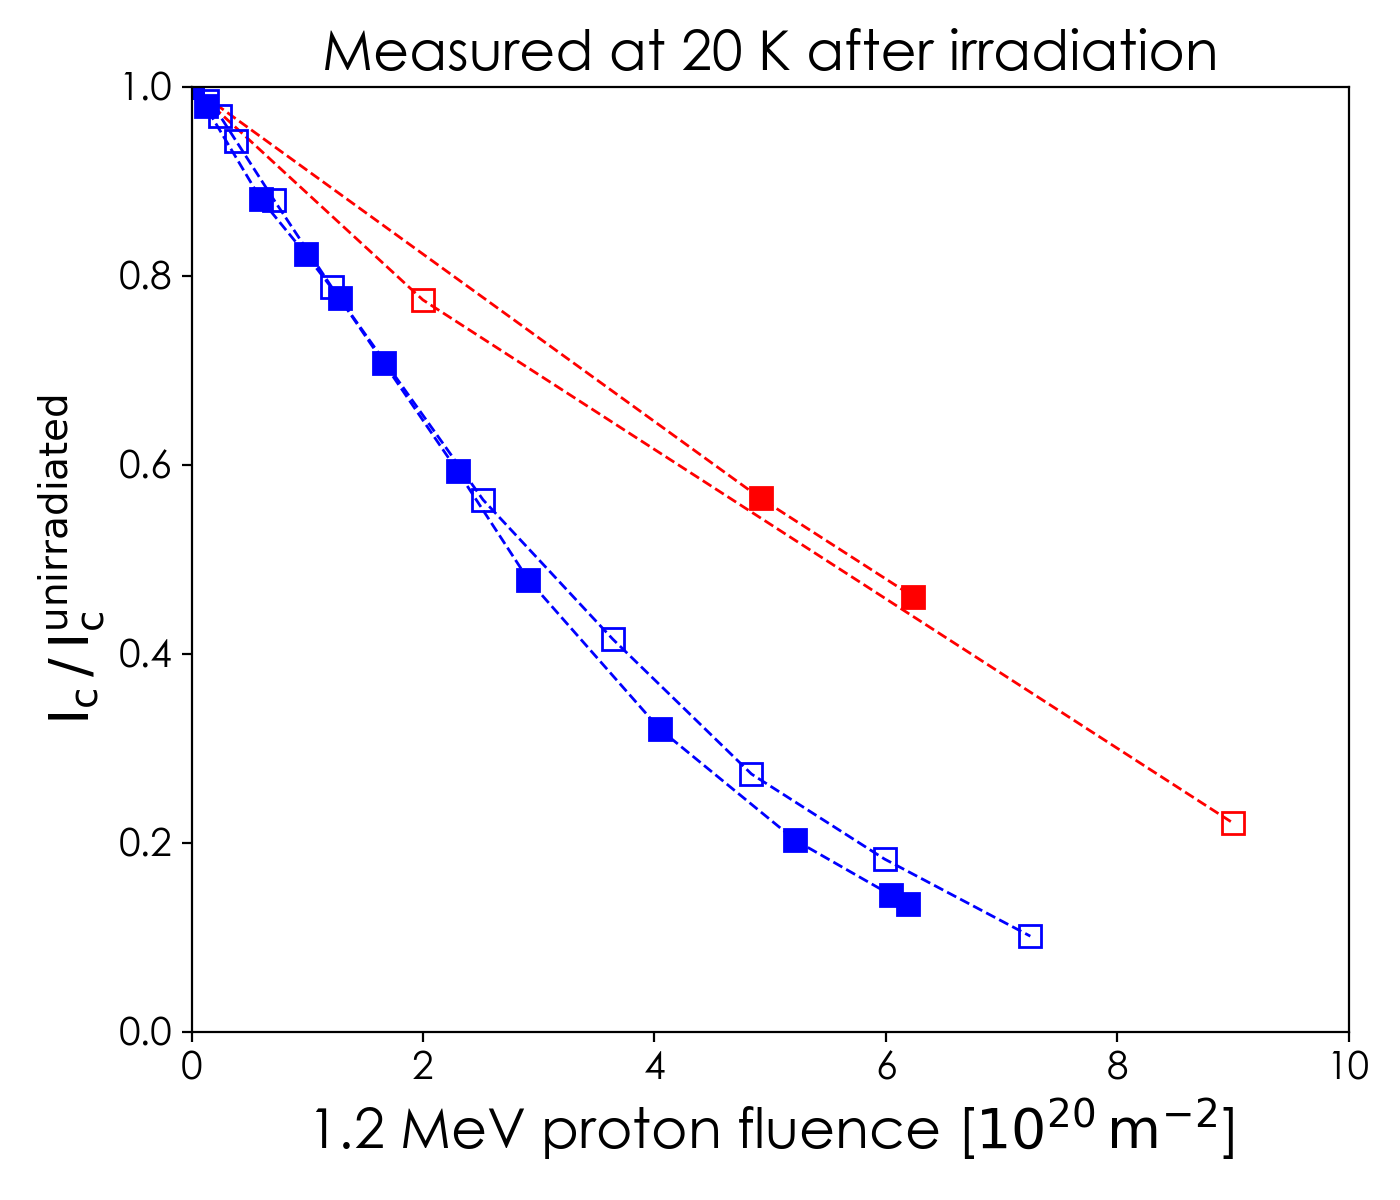

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(7, 6))
for tape, mfc, mec, ls in zip(['ffj26', 'ffj33', 'ffj23', 'ffj28'], ['r', 'None', 'b', 'None'], ['r', 'r', 'b', 'b'], ['--', '--', '--', '--']):
    means = data[(data.tapeid == tape)].drop('tapeid', axis=1).groupby('fluence').mean()
    ax.plot(means.index/1e20, means.ic/means.ic[0], marker='s', mec=mec, mfc=mfc, color=mec, linestyle=ls, linewidth=1)

ax.set_ylim(0, 1)
ax.set_xlim(0, 10)
ax.set_xlabel('1.2 MeV proton fluence [$\mathrm{10^{20}\, m^{-2}}$]')
ax.set_ylabel('$\mathrm{I_c\,/\,I_c^{unirradiated}}$')
ax.set_title('Measured at 20 K after irradiation')
fig.tight_layout()

ax.set_rasterized(True)
plt.savefig(outputDirectory+'figure08.svg')